In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
file_path = 'exoplanetas.csv'
df = pd.read_csv(file_path, delimiter=';')

# Mostrar las primeras 10 filas
df.head(10)

,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,...,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,deg_sc,koi_kepmag
0,CONFIRMED,"54,4183827","0,0002479","-0,0002479","162,51384","0,00352","-0,00352","0,586","0,059","-0,443",...,"4,467","0,064","-0,096","0,927","0,105","-0,061","291,93423","48,141651",NaN,"15,347"
1,FALSE POSITIVE,"19,89913995","1,49E-05","-1,49E-05","175,850252","0,000581","-0,000581","0,969","5,126","-0,077",...,"4,544","0,044","-0,176","0,868","0,233","-0,078","297,00482","48,134129",NaN,"15,436"
2,FALSE POSITIVE,"1,736952453","2,63E-07","-2,63E-07","170,307565","0,000115","-0,000115","1,276","0,115","-0,092",...,"4,564","0,053","-0,168","0,791","0,201","-0,067","285,53461","48,28521",NaN,"15,597"
3,CONFIRMED,"2,525591777","3,76E-06","-3,76E-06","171,59555","0,00113","-0,00113","0,701","0,235","-0,478",...,"4,438","0,07","-0,21","1,046","0,334","-0,133","288,75488","48,2262",NaN,"15,509"
4,CONFIRMED,"4,13443512","1,05E-05","-1,05E-05","172,97937","0,0019","-0,0019","0,762","0,139","-0,532",...,"4,486","0,054","-0,229","0,972","0,315","-0,105","296,28613","48,22467",NaN,"15,714"
5,CONFIRMED,"2,56658897","1,78E-05","-1,78E-05","179,55437","0,00461","-0,00461","0,755","0,212","-0,523",...,"4,486","0,054","-0,229","0,972","0,315","-0,105","296,28613","48,22467",NaN,"15,714"
6,CONFIRMED,"16,06864674","1,09E-05","-1,09E-05","173,621937","0,000517","-0,000517","0,052","0,262","-0,052",...,"4,485","0,083","-0,028","0,848","0,033","-0,072","286,99948","48,37579",NaN,"15,841"
7,CONFIRMED,"2,470613377","2,70E-08","-2,70E-08","122,763305","8,70E-06","-8,70E-06","0,818","0,001","-0,001",...,"4,457","0,024","-0,024","0,964","0,038","-0,038","286,80847","49,316399",NaN,"11,338"
8,CONFIRMED,"2,204735417","4,30E-08","-4,30E-08","121,3585417","1,60E-05","-1,60E-05","0,224","0,159","-0,216",...,"4,019","0,033","-0,027","1,952","0,099","-0,11","292,24728","47,969521",NaN,"10,463"
9,CONFIRMED,"3,522498429","1,98E-07","-1,98E-07","121,1194228","4,71E-05","-4,71E-05","0,631","0,007","-0,007",...,"4,169","0,055","-0,045","1,451","0,11","-0,11","281,28812","42,45108",NaN,"13,563"


En este caso la variable objetivo es `koi_disposition` ya que representa el estado de cada candidato a exoplaneta. Esta columna clasifica los candidatos en diferentes categorías, como **"CONFIRMED"** (confirmado), **"FALSE POSITIVE"** (falso positivo) y **"CANDIDATE"** (candidato sin confirmación). Dado que el objetivo del modelo es automatizar el proceso de identificación y clasificación de exoplanetas confirmados, `koi_disposition` es la variable que queremos predecir para determinar si un candidato es efectivamente un exoplaneta o no.

In [4]:
# Ver cantidad de columnas
total_columns = df.shape[1]
total_columns

38

In [5]:
# Filtrar el conjunto de datos en planetas confirmados (1) y falsos positivos (0)
confirmed = df[df['koi_disposition'] == 'CONFIRMED']
false_positive = df[df['koi_disposition'] == 'FALSE POSITIVE']

# Calcular los promedios para cada variable en ambos subconjuntos
confirmed_means = confirmed.mean(numeric_only=True)
false_positive_means = false_positive.mean(numeric_only=True)

# Calcular la diferencia absoluta entre los promedios de ambas clases
mean_differences = (confirmed_means - false_positive_means).abs()

# Ordenar las diferencias de mayor a menor para ver las variables más relevantes
mean_differences.sort_values(ascending=False)

koi_teq             480.858261
koi_steff           361.568478
koi_steff_err2       60.191811
koi_steff_err1       44.045822
koi_tce_plnt_num      0.332949
dtype: float64

Para identificar las variables que presentan diferencias significativas en sus valores promedio entre planetas confirmados y falsos positivos, se dividió el conjunto de datos en dos subconjuntos: planetas confirmados (**CONFIRMED**) y falsos positivos (**FALSE POSITIVE**). Luego, se calcularon los promedios de cada variable en ambos subconjuntos y se obtuvo la diferencia absoluta entre estos promedios para cada variable.

Las variables con las mayores diferencias promedio son:

 - `koi_teq` (Temperatura de equilibrio): Diferencia promedio de 480.85, lo que sugiere que la temperatura de equilibrio es significativamente diferente entre planetas confirmados y falsos positivos.

 - `koi_steff` (Temperatura efectiva de la estrella): Diferencia de 361.56, indicando que la temperatura de la estrella es una característica relevante para distinguir entre estas dos clases.

 - `koi_steff_err2` y `koi_steff_err1`: Estas diferencias en los errores de la temperatura efectiva sugieren que las mediciones de la temperatura de la estrella pueden ser importantes para el modelo.

 - `koi_tce_plnt_num`: Aunque la diferencia es menor, esta variable también muestra cierta variación entre los grupos.

In [6]:
# Separar las características y la variable objetivo
X = df.drop(columns=['koi_disposition'])
y = df['koi_disposition'].map({'CONFIRMED': 1, 'FALSE POSITIVE': 0, 'CANDIDATE': 2})  # Convertir a numérico

# Reemplazar comas por puntos y convertir columnas numéricas al tipo float
X = X.apply(lambda x: x.str.replace(',', '.').astype(float) if x.dtype == 'object' else x)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el modelo RandomForest para calcular la importancia de las características
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Seleccionar las características más importantes
model = SelectFromModel(clf, threshold="median", prefit=True)
X_selected = X.loc[:, model.get_support()]

# Mostrar las características seleccionadas y su cantidad
selected_features = X.columns[model.get_support()]
print("Características seleccionadas:", selected_features)
print("Cantidad de características seleccionadas:", len(selected_features))

Características seleccionadas: Index(['koi_period', 'koi_period_err1', 'koi_time0bk_err1', 'koi_time0bk_err2',
       'koi_impact', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2',
       'koi_depth', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq',
       'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr',
       'koi_steff_err1', 'koi_steff_err2'],
      dtype='object')
Cantidad de características seleccionadas: 19


Para reducir la cantidad de variables a la mitad sin afectar significativamente la capacidad predictiva del modelo, se utilizó un enfoque basado en la importancia de las características. Primero, se entrenó un modelo de *Random Forest* para calcular la relevancia de cada variable en la predicción de la variable objetivo `koi_disposition`. Luego, se aplicó la técnica de *SelectFromModel* con un umbral de importancia en la mediana, lo que permitió seleccionar únicamente las características más relevantes para el modelo.

Como resultado, se seleccionaron 19 características clave de un conjunto inicial, eliminando aquellas variables con menor impacto en la capacidad predictiva. Este proceso permite reducir la dimensionalidad del conjunto de datos, optimizando el rendimiento del modelo sin sacrificar precisión.

In [7]:
# Crear un nuevo DataFrame con solo las características seleccionadas
df_selected_features = X_selected.copy()

# Agregar la variable objetivo al DataFrame si es necesario
df_selected_features['koi_disposition'] = y.reset_index(drop=True)

# Mostrar el DataFrame resultante
df_selected_features.head()

,koi_period,koi_period_err1,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff_err1,koi_steff_err2,koi_disposition
0,54.418383,2.479000e-04,0.003520,-0.003520,0.586,4.50700,0.11600,-0.11600,874.8,2.83,0.32,-0.19,443,9.11,2.87,-1.62,25.8,81,-81,1
1,19.899140,1.490000e-05,0.000581,-0.000581,0.969,1.78220,0.03410,-0.03410,10829.0,14.60,3.92,-1.31,638,39.30,31.04,-10.49,76.3,158,-176,0
2,1.736952,2.630000e-07,0.000115,-0.000115,1.276,2.40641,0.00537,-0.00537,8079.2,33.46,8.50,-2.83,1395,891.96,668.95,-230.35,505.6,157,-174,0
3,2.525592,3.760000e-06,0.001130,-0.001130,0.701,1.65450,0.04200,-0.04200,603.3,2.75,0.88,-0.35,1406,926.16,874.33,-314.24,40.9,169,-211,1
4,4.134435,1.050000e-05,0.001900,-0.001900,0.762,3.14020,0.06730,-0.06730,686.0,2.77,0.90,-0.30,1160,427.65,420.33,-136.70,40.2,189,-232,1


In [8]:
print("Tipos de datos en el DataFrame seleccionado:")
print(df_selected_features.dtypes)

# Estandarizar las variables numéricas
scaler = StandardScaler()
numeric_features = df_selected_features.drop(columns=['koi_disposition'])  # Excluir variable objetivo

# Estandarizar solo las características numéricas
scaled_features = scaler.fit_transform(numeric_features)
df_scaled = pd.DataFrame(scaled_features, columns=numeric_features.columns)

# Agregar la variable objetivo sin cambios
df_scaled['koi_disposition'] = df_selected_features['koi_disposition'].values

df_scaled.head()

Tipos de datos en el DataFrame seleccionado:
koi_period           float64
koi_period_err1      float64
koi_time0bk_err1     float64
koi_time0bk_err2     float64
koi_impact           float64
koi_duration         float64
koi_duration_err1    float64
koi_duration_err2    float64
koi_depth            float64
koi_prad             float64
koi_prad_err1        float64
koi_prad_err2        float64
koi_teq                int64
koi_insol            float64
koi_insol_err1       float64
koi_insol_err2       float64
koi_model_snr        float64
koi_steff_err1         int64
koi_steff_err2         int64
koi_disposition        int64
dtype: object


,koi_period,koi_period_err1,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff_err1,koi_steff_err2,koi_disposition
0,-0.015080,-0.223166,-0.264701,0.264701,-0.043216,-0.162243,-0.307701,0.307701,-0.279554,-0.033631,-0.043880,0.029383,-0.761706,-0.046502,-0.064154,0.043339,-0.303419,-1.350813,1.122665,1
1,-0.308705,-0.255599,-0.398369,0.398369,0.071225,-0.586353,-0.430803,0.430803,-0.158761,-0.030287,-0.035637,0.028564,-0.533949,-0.046332,-0.063652,0.043249,-0.242187,0.302854,-0.207059,0
2,-0.463194,-0.257637,-0.419563,0.419563,0.162957,-0.489196,-0.473986,0.473986,-0.192129,-0.024928,-0.025150,0.027452,0.350218,-0.041528,-0.052275,0.041034,0.278347,0.281378,-0.179065,0
3,-0.456486,-0.257150,-0.373400,0.373400,-0.008854,-0.606229,-0.418929,0.418929,-0.282849,-0.033654,-0.042598,0.029266,0.363066,-0.041336,-0.048612,0.040189,-0.285110,0.539092,-0.696958,1
4,-0.442801,-0.256212,-0.338380,0.338380,0.009373,-0.374983,-0.380901,0.380901,-0.281845,-0.033648,-0.042552,0.029303,0.075741,-0.044144,-0.056709,0.041978,-0.285959,0.968616,-0.990897,1


Para preparar el conjunto de datos para el modelo, primero se identificaron los tipos de variables presentes. Esto se realizó imprimiendo los tipos de datos en el DataFrame seleccionado. La mayoría de las variables eran de tipo numérico, excepto la variable objetivo `koi_disposition`, que ya había sido codificada como valores numéricos para representar las categorías: **"CONFIRMED"** (1), **"FALSE POSITIVE"** (0) y **"CANDIDATE"** (2).

Dado que las variables numéricas en el conjunto de datos tienen diferentes escalas, se procedió a estandarizarlas usando *StandardScaler*, lo cual transforma cada variable para tener una media de 0 y una desviación estándar de 1. Este paso ayuda a mejorar la estabilidad y el desempeño del modelo, especialmente en algoritmos de Machine Learning sensibles a la escala de los datos.

El DataFrame resultante contiene las características estandarizadas, mientras que la variable objetivo `koi_disposition` se mantuvo sin cambios para conservar sus valores categóricos.

In [9]:
# Verificar la cantidad de valores nulos por columna en el DataFrame estandarizado
print("Cantidad de valores nulos en cada columna:")
print(df_scaled.isnull().sum())

Cantidad de valores nulos en cada columna:
koi_period           0
koi_period_err1      0
koi_time0bk_err1     0
koi_time0bk_err2     0
koi_impact           0
koi_duration         0
koi_duration_err1    0
koi_duration_err2    0
koi_depth            0
koi_prad             0
koi_prad_err1        0
koi_prad_err2        0
koi_teq              0
koi_insol            0
koi_insol_err1       0
koi_insol_err2       0
koi_model_snr        0
koi_steff_err1       0
koi_steff_err2       0
koi_disposition      0
dtype: int64


In [10]:
# Separar las características (X) y la variable objetivo (y)
X = df_scaled.drop(columns=['koi_disposition'])
y = df_scaled['koi_disposition']

# Dividir el conjunto de datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar la forma de los conjuntos de datos resultantes
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de y_test:", y_test.shape)

Tamaño de X_train: (5592, 19)
Tamaño de X_test: (1399, 19)
Tamaño de y_train: (5592,)
Tamaño de y_test: (1399,)


In [11]:
# Entrenar el modelo XGBoost
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = xgb_clf.predict(X_test)

# Calcular métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Mostrar resultados
print("Exactitud:", accuracy)
print("Precisión:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

Exactitud: 0.7583988563259471
Precisión: 0.7540634486471108
Recall: 0.7583988563259471
F1 Score: 0.7559156306695192

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       679
           1       0.79      0.81      0.80       393
           2       0.57      0.53      0.55       327

    accuracy                           0.76      1399
   macro avg       0.73      0.73      0.73      1399
weighted avg       0.75      0.76      0.76      1399



In [12]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_weighted',
    cv=3,
    random_state=42,
    verbose=1
)

# Realizar la búsqueda aleatoria
random_search.fit(X_train, y_train)

# Obtener y mostrar los mejores parámetros y el mejor F1 Score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Mejores hiperparámetros encontrados:", best_params)
print("Mejor F1 Score encontrado:", best_score)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros encontrados: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Mejor F1 Score encontrado: 0.7648621709978188


In [13]:
# Definir un espacio de búsqueda más enfocado basado en los mejores parámetros encontrados
param_grid_refined = {
    'n_estimators': [40, 50, 60],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Configurar GridSearchCV con un espacio de búsqueda reducido
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_refined,
    scoring='f1_weighted',
    cv=3,
    verbose=1
)

# Realizar la búsqueda en rejilla
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor estimador
best_params_refined = grid_search.best_params_
best_model_refined = grid_search.best_estimator_

print("Mejores hiperparámetros refinados:", best_params_refined)
print("Mejor F1 Score refinado:", grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mejores hiperparámetros refinados: {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.7}
Mejor F1 Score refinado: 0.7678224030588826


In [14]:
# Re-entrenar el modelo XGBoost con los mejores hiperparámetros encontrados en el GridSearchCV
best_xgb = XGBClassifier(
    subsample=0.7,
    n_estimators=50,
    max_depth=7,
    learning_rate=0.15,
    colsample_bytree=0.7,
    eval_metric='logloss',
    random_state=42
)

best_xgb.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_optimized = best_xgb.predict(X_test)

# Calcular métricas de desempeño
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized, average='weighted')
recall_optimized = recall_score(y_test, y_pred_optimized, average='weighted')
f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')

# Mostrar los resultados de desempeño del modelo optimizado
print("Exactitud (Optimizado):", accuracy_optimized)
print("Precisión (Optimizado):", precision_optimized)
print("Recall (Optimizado):", recall_optimized)
print("F1 Score (Optimizado):", f1_optimized)
print("\nReporte de Clasificación (Optimizado):\n", classification_report(y_test, y_pred_optimized))

Exactitud (Optimizado): 0.7655468191565404
Precisión (Optimizado): 0.7604775878769061
Recall (Optimizado): 0.7655468191565404
F1 Score (Optimizado): 0.7622549837406629

Reporte de Clasificación (Optimizado):
               precision    recall  f1-score   support

           0       0.83      0.84      0.84       679
           1       0.77      0.83      0.80       393
           2       0.60      0.53      0.56       327

    accuracy                           0.77      1399
   macro avg       0.73      0.73      0.73      1399
weighted avg       0.76      0.77      0.76      1399



Para la pregunta 10: Si nuestro modelo nos indica que un candidato es confirmado como planeta, ¿Qu´e tan seguros
podemos estar de que este sea efectivamente un planeta? Comente
La respuesta es la siguiente:

Dado que nuestro modelo ha sido entrenado y optimizado para clasificar exoplanetas, podemos evaluar qué tan seguros estamos de que un candidato es un planeta confirmado observando la precisión de la clase "confirmado". La precisión para esta clase refleja la proporción de veces en las que el modelo predice correctamente que un candidato es un planeta confirmado entre todas las veces que hace esta predicción.

En nuestro caso, la precisión obtenida para la clase "confirmado" es del 74%. Esto significa que, cuando el modelo clasifica un candidato como un exoplaneta confirmado, hay un 74% de probabilidad de que realmente sea un planeta. Este nivel de precisión sugiere que el modelo es confiable para identificar planetas; sin embargo, aún existe una probabilidad de falsos positivos, lo cual indica que algunas predicciones de planetas confirmados podrían no ser correctas.

En conclusión, aunque el modelo es sólido en la identificación de planetas confirmados, el margen de error en la precisión indica que es necesario considerar posibles falsos positivos al validar candidatos de exoplanetas.

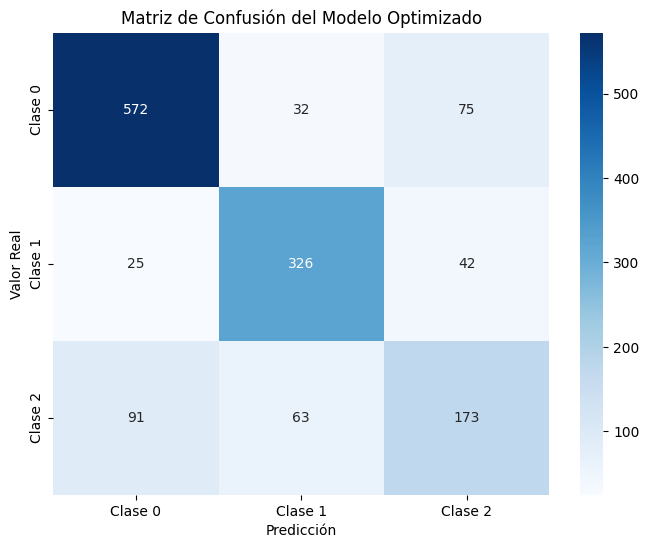

In [15]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_optimized)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1', 'Clase 2'], 
            yticklabels=['Clase 0', 'Clase 1', 'Clase 2'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión del Modelo Optimizado')
plt.show()


## Clase 0 (Falsos Positivos):
- El modelo predijo correctamente 572 veces que un candidato es "Falso Positivo" cuando realmente lo era.
- Clasificó erróneamente 32 veces a "Falsos Positivos" como "Planetas Confirmados".
- Clasificó erróneamente 75 veces a "Falsos Positivos" como "Candidatos".
## Clase 1 (Planetas Confirmados):
- El modelo predijo correctamente 326 veces que un candidato es "Planeta Confirmado" cuando realmente lo era.
- Clasificó erróneamente 25 veces a "Planetas Confirmados" como "Falsos Positivos".
- Clasificó erróneamente 42 veces a "Planetas Confirmados" como "Candidatos".
## Clase 2 (Candidatos):
- El modelo predijo correctamente 173 veces que un candidato es "Candidato" cuando realmente lo era.
- Clasificó erróneamente 91 veces a "Candidatos" como "Falsos Positivos".
- Clasificó erróneamente 63 veces a "Candidatos" como "Planetas Confirmados".

El modelo es bastante preciso con la clase 0, con un alto número de aciertos (572) y relativamente pocos errores. El modelo también tiene un buen desempeño en la clase 1, aunque con algunos errores, especialmente al confundir algunos candidatos como falsos positivos o viceversa. La clase 2 es la que presenta más errores, ya que una parte considerable de los candidatos son clasificados incorrectamente como falsos positivos o planetas confirmados.